In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from single_dorm_simulation import SingleDormSimulation

In [2]:
def sample_dorm_infection_data(contacts_per_day, 
                               base_test_rate,
                               high_alert_test_rate,
                               safe_days_to_exit_high_alert, 
                               use_outside_infections,
                               procnum, return_dict):
    high_alert_contacts_per_day = contacts_per_day
    dorm_sim = SingleDormSimulation(dorm_population=100,
                                    dorm_test_rate=base_test_rate,
                                    high_alert_dorm_test_rate=high_alert_test_rate,
                                    contacts_per_day=contacts_per_day,
                                    high_alert_contacts_per_day=high_alert_contacts_per_day,
                                    safe_days_to_exit_high_alert=safe_days_to_exit_high_alert,
                                    use_default_outside_infection_p=use_outside_infections,
                                    initial_cases=1)
    all_trajectories_days_controlled, \
    all_trajectories_total_infected, \
    all_trajectories_free_infected_counts, \
    all_trajectories_high_alert_statuses = dorm_sim.run_multiple_new_trajectories(ntrajectories=500)
    
    return_dict[procnum] = {
        'days_controlled': all_trajectories_days_controlled, 
        'total_infected': all_trajectories_total_infected, 
        'free_infected_counts': all_trajectories_free_infected_counts, 
        'high_alert_statuses': all_trajectories_high_alert_statuses
    }


    

In [3]:
import multiprocessing, time, itertools

manager = multiprocessing.Manager()
return_dict = manager.dict()

base_test_rates = [0.2, 2/7]
contacts_per_day = 8.3*1.25
high_test_rates = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
use_outside_infections = True
safe_days_to_exit_high_alert = [3, 5, 7, 9, 11]

jobs = []


start = time.time()
idx = 0
idx_mapping = {}
mapping_to_idx = {}
for base_rate, high_test_rate, safe_days in itertools.product(
                                                base_test_rates, 
                                                high_test_rates, 
                                                safe_days_to_exit_high_alert):
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts_per_day, 
                                      base_rate,
                                      high_test_rate, 
                                      safe_days,
                                      use_outside_infections,
                                      idx,return_dict))
    idx_mapping[idx] = (base_rate, high_test_rate, safe_days)
    mapping_to_idx[(base_rate, high_test_rate, safe_days)] = idx
    jobs.append(p)
    p.start()
    idx += 1
    
non_adaptive_base_rates = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]
safe_days=3
for base_rate in non_adaptive_base_rates:
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts_per_day, 
                                      base_rate,
                                      base_rate, 
                                      safe_days,
                                      use_outside_infections,
                                      idx,return_dict))
    idx_mapping[idx] = (base_rate, base_rate, safe_days)
    mapping_to_idx[(base_rate, base_rate, safe_days)] = idx
    jobs.append(p)
    p.start()
    idx += 1
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 5524.27 seconds


In [28]:
# re-simulate with 1/7 base test-rate


base_test_rates = [1/7]
contacts_per_day = 8.3*1.25
high_test_rates = [1/7, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
use_outside_infections = True
safe_days_to_exit_high_alert = [3, 5, 7, 9, 11]




start = time.time()

for base_rate, high_test_rate, safe_days in itertools.product(
                                                base_test_rates, 
                                                high_test_rates, 
                                                safe_days_to_exit_high_alert):
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts_per_day, 
                                      base_rate,
                                      high_test_rate, 
                                      safe_days,
                                      use_outside_infections,
                                      idx,return_dict))
    idx_mapping[idx] = (base_rate, high_test_rate, safe_days)
    mapping_to_idx[(base_rate, high_test_rate, safe_days)] = idx
    jobs.append(p)
    p.start()
    idx += 1
    
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 2708.90 seconds


In [45]:
# re-simulate with larger range of non-adaptive base rates

start = time.time()

non_adaptive_base_rates = [0.14, 0.16, 0.18]
safe_days=3
for base_rate in non_adaptive_base_rates:
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts_per_day, 
                                      base_rate,
                                      base_rate, 
                                      safe_days,
                                      use_outside_infections,
                                      idx,return_dict))
    idx_mapping[idx] = (base_rate, base_rate, safe_days)
    mapping_to_idx[(base_rate, base_rate, safe_days)] = idx
    jobs.append(p)
    p.start()
    idx += 1
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 965.34 seconds


In [5]:
def get_avg_daily_tests_per_person(base_rate, high_rate, safe_days):
    idx = mapping_to_idx[(base_rate, high_rate, safe_days)]

    sum_avg_daily_tests = 0
    for trajectory_statuses in return_dict[idx]['high_alert_statuses']:
        high_alert_days = sum(trajectory_statuses)

        avg_daily_tests = high_alert_days * high_rate * 100 + (112 - high_alert_days) * base_rate * 100
        sum_avg_daily_tests += avg_daily_tests / 112

    return sum_avg_daily_tests / len(return_dict[idx]['high_alert_statuses']) / 100

In [6]:
def get_avg_infections(base_rate, high_rate, safe_days):
    idx = mapping_to_idx[(base_rate, high_rate, safe_days)]
    return np.mean(return_dict[idx]['total_infected'])

In [46]:
avg_daily_tests = {}

for (base_rate, high_rate, safe_days) in mapping_to_idx.keys():
    avg_daily_tests[(base_rate, high_rate, safe_days)] = get_avg_daily_tests_per_person(base_rate, high_rate, safe_days)

In [47]:
avg_infections = {}
avg_q50s = {}
for (base_rate, high_rate, safe_days) in mapping_to_idx.keys():
    avg_infections[(base_rate, high_rate, safe_days)] = get_avg_infections(base_rate, high_rate, safe_days)

In [67]:
min(avg_daily_tests.values()) * 6920

968.8000000000001

In [74]:
max(avg_daily_tests.values()) * 6920

3000.6885306122554

In [72]:
[key for key, val in avg_daily_tests.items() if val == max(avg_daily_tests.values())]

[(0.2857142857142857, 0.9, 11)]

In [9]:
max(avg_daily_tests)

0.43362551020408313

In [57]:
test_range = np.linspace(0.14, 0.4, 15)

adaptive_20_baseline = []
adaptive_2_7_baseline = []
adaptive_1_7_baseline = []
non_adaptive = []

for max_test in test_range:
    adaptive_20_best = 101
    adaptive_2_7_best = 101
    non_adaptive_best = 101
    adaptive_1_7_best = 101
    
    for (base_rate, high_rate, safe_days) in mapping_to_idx:
        if avg_daily_tests[(base_rate, high_rate, safe_days)] <= max_test:
            avg_inf = avg_infections[(base_rate, high_rate, safe_days)]
            if high_rate == base_rate:
                if avg_inf < non_adaptive_best:
                    non_adaptive_best = avg_inf
            elif base_rate == 0.2:
                if avg_inf < adaptive_20_best:
                    adaptive_20_best = avg_inf
            elif base_rate == 2/7:
                if avg_inf < adaptive_2_7_best:
                    adaptive_2_7_best = avg_inf
            elif base_rate == 1/7:
                if avg_inf < adaptive_1_7_best:
                    adaptive_1_7_best = avg_inf
            else:
                print("couldn't identify type for {}".format((base_rate, high_rate, safe_days)))
    adaptive_20_baseline.append(adaptive_20_best)
    adaptive_2_7_baseline.append(adaptive_2_7_best)
    non_adaptive.append(non_adaptive_best)
    adaptive_1_7_baseline.append(adaptive_1_7_best)
    

In [49]:
avg_daily_tests[(1/7, 1/7, 3)]

0.1428571428571443

In [50]:
avg_infections[(1/7, 1/7, 3)]

62.0

In [51]:
avg_infections[(0.2, 0.2, 3)]

38.0

In [52]:
avg_daily_tests[(0.2, 0.2, 3)]

0.2

In [53]:
1/7

0.14285714285714285

Text(0.5,1,'Tradeoff Between Health Outcomes and Daily Testing Capacity\nfor Adaptive and Non-Adaptive Testing Protocols')

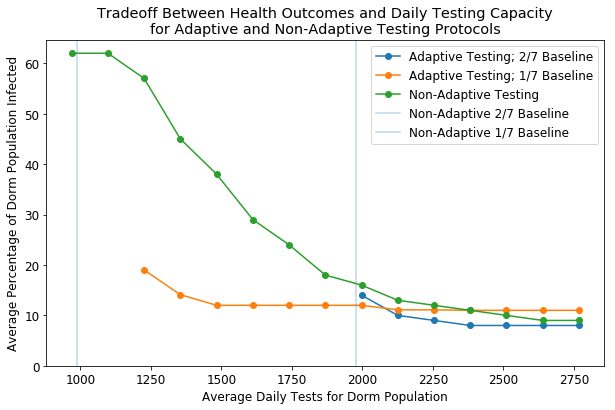

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

scaled_test_range = [tests * 6920 for tests in test_range]

plt.figure(figsize=(10,6))
#plt.plot(scaled_test_range[4:], adaptive_20_baseline[4:], marker='o', label='Adaptive Testing; 1/5 Baseline')
plt.plot(scaled_test_range[8:], adaptive_2_7_baseline[8:], marker='o', label='Adaptive Testing; 2/7 Baseline')
plt.plot(scaled_test_range[2:], adaptive_1_7_baseline[2:], marker='o', label='Adaptive Testing; 1/7 Baseline')
plt.plot(scaled_test_range, non_adaptive, marker='o', label='Non-Adaptive Testing')

plt.ylim(ymin=0)

plt.axvline(2/7 * 6920, label='Non-Adaptive 2/7 Baseline', alpha=0.3)
#plt.axvline(1/5 * 6920, label='Non-Adaptive 1/5 Baseline', alpha=0.3)
plt.axvline(1/7 * 6920, label='Non-Adaptive 1/7 Baseline', alpha=0.3)
plt.legend()
plt.xlabel("Average Daily Tests for Dorm Population")
plt.ylabel("Average Percentage of Dorm Population Infected")
plt.title("Tradeoff Between Health Outcomes and Daily Testing Capacity\n"
         "for Adaptive and Non-Adaptive Testing Protocols")

In [78]:
adaptive_1_7_baseline[3]

14.100000000000023

In [79]:
[key for key, val in avg_infections.items() if val == adaptive_1_7_baseline[3]]

[(0.2, 0.5, 3), (0.14285714285714285, 0.6, 3)]

In [86]:
avg_daily_tests[(0.14285714285714285, 0.6, 3)] * 6920

1320.2795102040807

In [81]:
avg_infections[(0.28, 0.28 ,3)]

16.0

In [84]:
avg_daily_tests[(0.28, 0.28, 3)] * 6920

1937.6000000000001

Text(0.5,1,'90th Quantile of Total-Infection Distribution in 100-person Dorm\nover 16-Week Period with Zero Outside Infections')

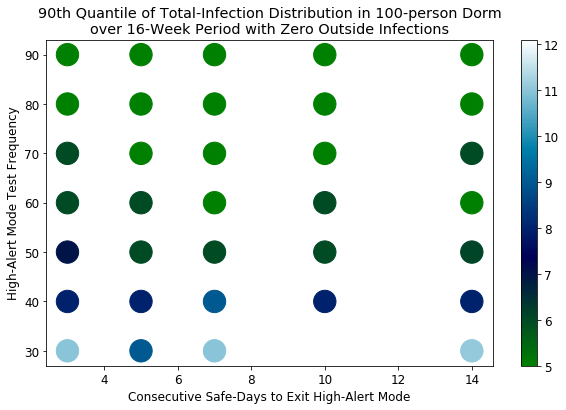

In [29]:
xs = []
ys = []
zs_inf = []
plt.rcParams.update({'font.size': 12})
for j, safe_days in enumerate(safe_days_to_exit_high_alert):
    for i, test_rate in enumerate(high_test_rates):
        xs.append(safe_days)
        ys.append(test_rate * 100)
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
        zs_inf.append(np.quantile(return_dict[idx]['total_infected'], 0.9))

plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs_inf, s=500, cmap='ocean')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("90th Quantile of Total-Infection Distribution in 100-person Dorm\n"
          "over 16-Week Period with Zero Outside Infections")

Text(0.5,1,'Average Daily Tests Performed by Adaptive High-Alert Protocol')

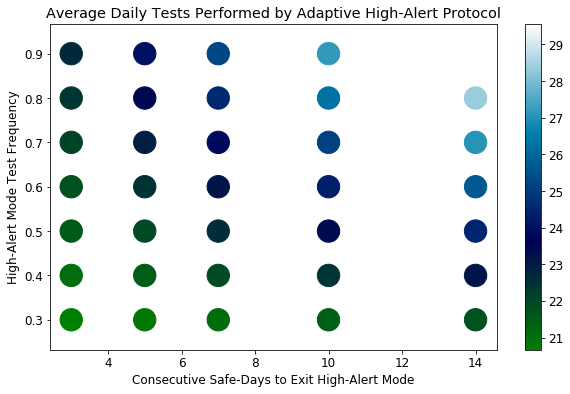

In [30]:
xs = []
ys = []
zs_test = []
for j, safe_days in enumerate(safe_days_to_exit_high_alert):
    for i, test_rate in enumerate(high_test_rates):
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
           
        xs.append(safe_days)
        ys.append(test_rate)
        
        
        sum_avg_daily_tests = 0
        for trajectory_statuses in return_dict[idx]['high_alert_statuses']:
            high_alert_days = sum(trajectory_statuses)
        
            avg_daily_tests = high_alert_days * test_rate * 100 + (112 - high_alert_days) * base_test_rate * 100
            sum_avg_daily_tests += avg_daily_tests / 112
            
        zs_test.append(sum_avg_daily_tests / len(return_dict[idx]['high_alert_statuses']))
        
plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs_test, s=500, cmap='ocean')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("Average Daily Tests Performed by Adaptive High-Alert Protocol")

In [35]:
def get_best_params(max_test_capacity):
    idx = 0
    best_safe_days = 0
    best_test_rate = 0
    best_inf = 100
    
    for safe_days in safe_days_to_exit_high_alert:
        for test_rate in high_test_rates:
            
            if zs_test[idx] <= max_test_capacity:
                if zs_inf[idx] < best_inf:
                    best_inf = zs_inf[idx]
                    best_safe_days = safe_days
                    best_test_rate = test_rate
            idx += 1
    
    return best_safe_days, best_test_rate, best_inf

In [51]:
# investigate pareto frontier b/w test capacity and 90th quantile infections
test_capacity_range = np.linspace(min(zs_test), max(zs_test), 20)
xs_test_cap = []
ys_best_inf = []
best_protocols = []
for test_cap in test_capacity_range:
    xs_test_cap.append(test_cap)
    safe_days, test_rate, best_inf = get_best_params(test_cap)
    ys_best_inf.append(best_inf)
    best_protocols.append((safe_days, test_rate))

Text(0.5,1,'Pareto Frontier between Total Infections vs. Testing Capacity \nAssuming Zero Outside Infections')

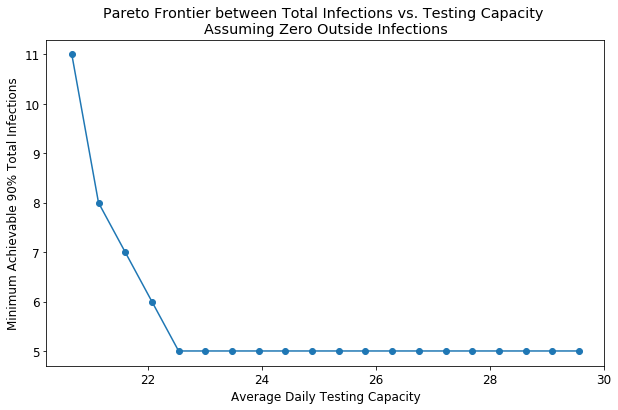

In [53]:
plt.figure(figsize=(10,6))
plt.plot(xs_test_cap, ys_best_inf, marker='o')
plt.xlabel("Average Daily Testing Capacity")
plt.ylabel("Minimum Achievable 90% Total Infections")
plt.title("Pareto Frontier between Total Infections vs. Testing Capacity \n"
         "Assuming Zero Outside Infections")

In [43]:
best_protocols

[(3, 0.3),
 (3, 0.3),
 (5, 0.3),
 (5, 0.3),
 (3, 0.4),
 (3, 0.4),
 (3, 0.4),
 (3, 0.4),
 (3, 0.5),
 (3, 0.6),
 (3, 0.6),
 (3, 0.6),
 (3, 0.6),
 (3, 0.6),
 (3, 0.8),
 (3, 0.8),
 (3, 0.8),
 (3, 0.8),
 (3, 0.8),
 (3, 0.8)]

In [44]:
mapping_to_idx.keys()

dict_keys([(11.3, 0.2, 0.3, 3), (11.3, 0.2, 0.3, 5), (11.3, 0.2, 0.3, 7), (11.3, 0.2, 0.3, 10), (11.3, 0.2, 0.3, 14), (11.3, 0.2, 0.4, 3), (11.3, 0.2, 0.4, 5), (11.3, 0.2, 0.4, 7), (11.3, 0.2, 0.4, 10), (11.3, 0.2, 0.4, 14), (11.3, 0.2, 0.5, 3), (11.3, 0.2, 0.5, 5), (11.3, 0.2, 0.5, 7), (11.3, 0.2, 0.5, 10), (11.3, 0.2, 0.5, 14), (11.3, 0.2, 0.6, 3), (11.3, 0.2, 0.6, 5), (11.3, 0.2, 0.6, 7), (11.3, 0.2, 0.6, 10), (11.3, 0.2, 0.6, 14), (11.3, 0.2, 0.7, 3), (11.3, 0.2, 0.7, 5), (11.3, 0.2, 0.7, 7), (11.3, 0.2, 0.7, 10), (11.3, 0.2, 0.7, 14), (11.3, 0.2, 0.8, 3), (11.3, 0.2, 0.8, 5), (11.3, 0.2, 0.8, 7), (11.3, 0.2, 0.8, 10), (11.3, 0.2, 0.8, 14), (11.3, 0.2, 0.9, 3), (11.3, 0.2, 0.9, 5), (11.3, 0.2, 0.9, 7), (11.3, 0.2, 0.9, 10), (11.3, 0.2, 0.9, 14)])

Text(0.5,1,'distribution of total infections, with parameters:\nhigh-alert test frequency: 30%\nbaseline dorm contacts/day: 11.3')

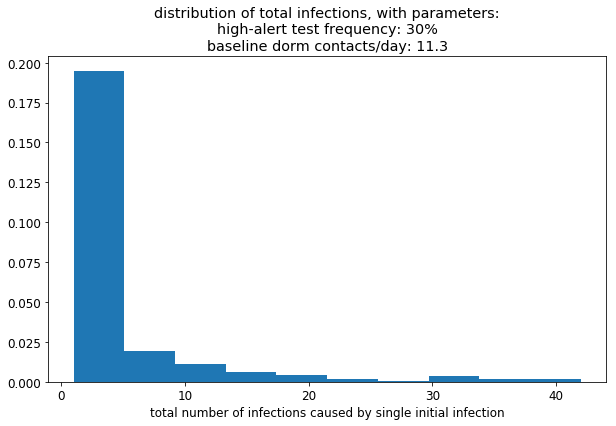

In [48]:
idx = mapping_to_idx[(11.3, 0.2, 0.3, 3)]
t = return_dict[idx]['total_infected']
plt.figure(figsize=(10,6))
plt.hist(t, normed=True)
plt.xlabel("total number of infections caused by single initial infection")
plt.title("distribution of total infections, with parameters:\n" 
          "high-alert test frequency: 30%\n"
          "baseline dorm contacts/day: 11.3")

Text(0.5,1,'distribution of total infections, with parameters:\nhigh-alert test frequency: 70%\nbaseline dorm contacts/day: 11.3')

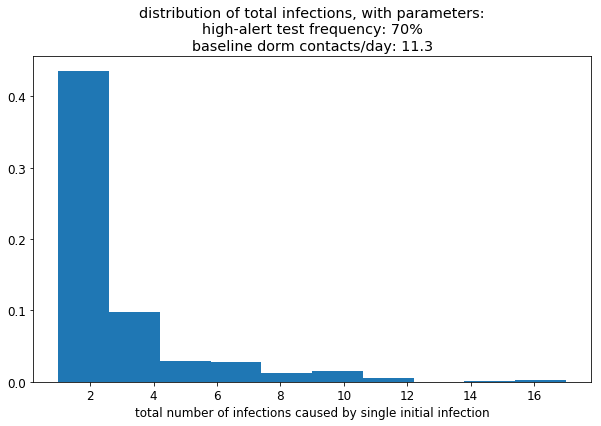

In [49]:
idx = mapping_to_idx[(11.3, 0.2, 0.7, 3)]
t = return_dict[idx]['total_infected']
plt.figure(figsize=(10,6))
plt.hist(t, normed=True)
plt.xlabel("total number of infections caused by single initial infection")
plt.title("distribution of total infections, with parameters:\n" 
          "high-alert test frequency: 70%\n"
          "baseline dorm contacts/day: 11.3")